#### PyTorch Lightning: для воспроизведения экспериментов
#### TensorBoard + Optuna: для логирования экспериментов и подбора гиперпараметров 
#### Albumentations: для аугментаций
#### timm: для использования предобученных моделей для задачи классификации 
#### captum: для анализа в каких областях изображения у модели наибольшие градиенты, аккумулированные по всем слоям
#### ONNX: для инференса 

In [1]:
# IMPORTS AND CONFIG CLASS

import os
import random
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import optuna
import pandas as pd
import pytorch_lightning as pl
import timm
import torch
import torch.nn as nn
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    MedianBlur,
    MotionBlur,
    Normalize,
    RandomResizedCrop,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2
from captum.attr import IntegratedGradients
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import f1_score
from tqdm import tqdm


class Config:
    PATH_DATA = "/home/a.makarchuk@rit.va/Desktop/kaggle-CV-best11/dogs_vs_cats/data/"
    IMAGE_SIZE = (256, 256)
    IMAGE_SIZE_TEST = (320, 320)
    BATCH_SIZE = 10
    EPOCHS = 1
    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
    TRAIN_RATIO = 0.9
    SEED = 42
    PERCENT = 0.05

/home/a.makarchuk@rit.va/miniconda3/envs/kaggle_cv_best11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# DEFINE CORE FUNCTIONS


def set_seed(seed):
    """Sets random seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


def calculate_mean_std(image_paths: list, percent: float) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates mean and std of images based on a percentage of data."""
    num_images = int(len(image_paths) * percent)

    mean = np.mean(
        [
            np.mean(
                plt.imread(f"{Config.PATH_DATA}/train/{path}").astype(float) / 255.0, axis=(0, 1)
            )
            for path in image_paths[:num_images]
        ],
        axis=0,
    )

    std = np.mean(
        [
            np.std(
                plt.imread(f"{Config.PATH_DATA}/train/{path}").astype(float) / 255.0, axis=(0, 1)
            )
            for path in image_paths[:num_images]
        ],
        axis=0,
    )

    return mean, std


def get_transforms(
    mean: np.ndarray, std: np.ndarray, image_size: Tuple[int, int], is_train: bool = True
):
    """Returns transforms for training or validation/testing."""
    if is_train:
        return Compose(
            [
                Resize(*image_size),
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        return Compose(
            [
                Resize(*image_size),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )


class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths: list, transforms=None):
        """
        Dataset for Cats vs Dogs classification.

        Args:
            image_paths (list): List of image paths.
            transforms (albumentations.Compose): Image transformations.
        """
        self.image_paths = image_paths
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img_name = img_path.split("/")[-1]
        label = 1 if img_name.split(".")[0] == "dog" else 0

        img = cv2.imread(Config.PATH_DATA + "train/" + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return img, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.image_paths)


def create_dataloader(
    image_paths: list,
    transforms: Compose,
    batch_size: int,
    num_workers: int,
    shuffle: bool = False,
):
    """Creates a DataLoader from a list of image paths."""
    dataset = CatsDogsDataset(image_paths, transforms)
    return torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )


class LitModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 1,
        pretrained: bool = True,
        lr: float = 5e-4,
        thr: float = 0.5,
    ):
        """
        Lightning module for image classification.

        Args:
            model_name (str): Name of the model architecture.
            num_classes (int): Number of classes.
            pretrained (bool): Whether to use pretrained weights.
            lr (float): Learning rate.
            thr (float): Threshold for classification.
        """
        super().__init__()
        self.model = timm.create_model(model_name, num_classes=num_classes, pretrained=pretrained)
        self.lr = lr
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.thr = thr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self.model(x).view(-1)
        loss = self.bce_loss(y_pred, y_true)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self.model(x).view(-1)
        loss = self.bce_loss(y_pred, y_true)
        self.log("val_loss", loss)

        preds = (torch.sigmoid(y_pred) > self.thr).float()
        f1 = f1_score(y_true.cpu().numpy(), preds.cpu().numpy())
        self.log("val_f1", f1)

        bce_loss_thr = nn.BCELoss()(preds, y_true)
        self.log("val_loss_thr", bce_loss_thr)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def load_model_from_checkpoint(checkpoint_path: str, model_name: str) -> LitModel:
    """Loads a model from a checkpoint."""
    model = LitModel.load_from_checkpoint(checkpoint_path, model_name=model_name)
    model.eval()
    return model

In [5]:
# DATA PREPARATION

set_seed(Config.SEED)

train_image_paths = os.listdir(f"{Config.PATH_DATA}train")
test_image_paths = os.listdir(f"{Config.PATH_DATA}test1")

mean, std = calculate_mean_std(train_image_paths, Config.PERCENT)
print(f"Mean: {mean}, Std: {std}")

train_transforms = get_transforms(mean, std, Config.IMAGE_SIZE, is_train=True)
val_transforms = get_transforms(mean, std, Config.IMAGE_SIZE_TEST, is_train=False)

random.shuffle(train_image_paths)
train_image_paths = train_image_paths[: int(len(train_image_paths) * Config.TRAIN_RATIO)]
val_image_paths = train_image_paths[int(len(train_image_paths) * Config.TRAIN_RATIO) :]

train_dataloader = create_dataloader(
    train_image_paths, train_transforms, Config.BATCH_SIZE, num_workers=4, shuffle=True
)
val_dataloader = create_dataloader(
    val_image_paths, val_transforms, Config.BATCH_SIZE, num_workers=4
)

Mean: [0.49031324 0.45440296 0.41580029], Std: [0.22885894 0.22473903 0.2244801 ]


In [11]:
# HYPERPARAMETER TUNING


def objective(trial):
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    thr = trial.suggest_float("thr", 0.3, 0.8)

    model = LitModel("mobilenetv4_conv_large.e500_r256_in1k", thr=thr, lr=lr)

    logger = TensorBoardLogger(f"{Config.PATH_DATA}/tb_logs", name="optuna")
    early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
    checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

    trainer = pl.Trainer(
        logger=logger,
        max_epochs=Config.EPOCHS,
        accelerator="auto",
        callbacks=[early_stop, checkpoint],
    )

    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics["val_loss_thr"].item()


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params

[I 2024-07-11 17:07:37,413] A new study created in memory with name: no-name-767a016e-af6b-4cb7-b208-ff100eb4f354
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MobileNetV3       | 31.3 M | train
1 | bce_loss | BCEWithLogitsLoss | 0      | train
-------------------------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.245   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/home/a.makarchuk@rit.va/miniconda3/envs/kaggle_cv_best11/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[W 2024-07-11 17:08:06,733] Trial 0 failed with parameters: {'lr': 5.188697866489099e-05, 'thr': 0.31911095162952263} because of the following error: KeyError('val_loss_thr').
Traceback (most recent call last):
  File "/home/a.makarchuk@rit.va/miniconda3/envs/kaggle_cv_best11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_45669/3965348370.py", line 22, in objective
    return trainer.callback_metrics["val_loss_thr"].item()
           ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'val_loss_thr'
[W 2024-07-11 17:08:06,735] Trial 0 failed with value None.


KeyError: 'val_loss_thr'

In [14]:
# TRAIN THE FINAL MODEL

model = LitModel(
    "mobilenetv4_conv_large.e500_r256_in1k", thr=best_params["thr"], lr=best_params["lr"]
)

logger = TensorBoardLogger(f"{Config.PATH_DATA}/tb_logs", name="best")
early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

trainer = pl.Trainer(
    logger=logger,
    max_epochs=Config.EPOCHS,
    accelerator="auto",
    callbacks=[early_stop, checkpoint],
)

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MobileNetV3       | 31.3 M | train
1 | bce_loss | BCEWithLogitsLoss | 0      | train
-------------------------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.245   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/home/a.makarchuk@rit.va/miniconda3/envs/kaggle_cv_best11/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [6]:
# PREDICT ON TEST SET

best_model = load_model_from_checkpoint(
    f"{Config.PATH_DATA}tb_logs/best/version_1/checkpoints/epoch=0-step=2250.ckpt",
    "mobilenetv4_conv_large.e500_r256_in1k",
)

dummy_input = torch.randn(1, 3, *(Config.IMAGE_SIZE_TEST))
torch.onnx.export(best_model, dummy_input, f"{Config.PATH_DATA}model.onnx", opset_version=11)

ort_session = ort.InferenceSession(f"{Config.PATH_DATA}model.onnx")

test_preds = []
for img_path in tqdm(test_image_paths):
    img = cv2.imread(f"{Config.PATH_DATA}test1/{img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = val_transforms(image=img)["image"]
    img = img.unsqueeze(0)

    input_name = ort_session.get_inputs()[0].name
    input_data = img.numpy()

    pred = ort_session.run(None, {input_name: input_data})[0]
    pred = torch.sigmoid(torch.from_numpy(pred)).item()

    test_preds.append(pred)

test_preds_df = pd.DataFrame(
    {
        "id": [int(path.split(".")[0]) for path in test_image_paths],
        "label": test_preds,
    }
)

test_preds_df = test_preds_df.sort_values("id").reset_index(drop=True)
test_preds_df.to_csv(f"{Config.PATH_DATA}advanced_solution.csv", index=False)

============ Diagnostic Run torch.onnx.export version 2.0.0.post101 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



100%|█████████████████████████████████████| 12500/12500 [05:45<00:00, 36.20it/s]


/home/a.makarchuk@rit.va/Desktop/kaggle-CV-best11/dogs_vs_cats/data/test1/11461.jpg
0.9999997615814209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14129.363259852336..12492.497447584337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14129.363259852336..12492.497447584337].


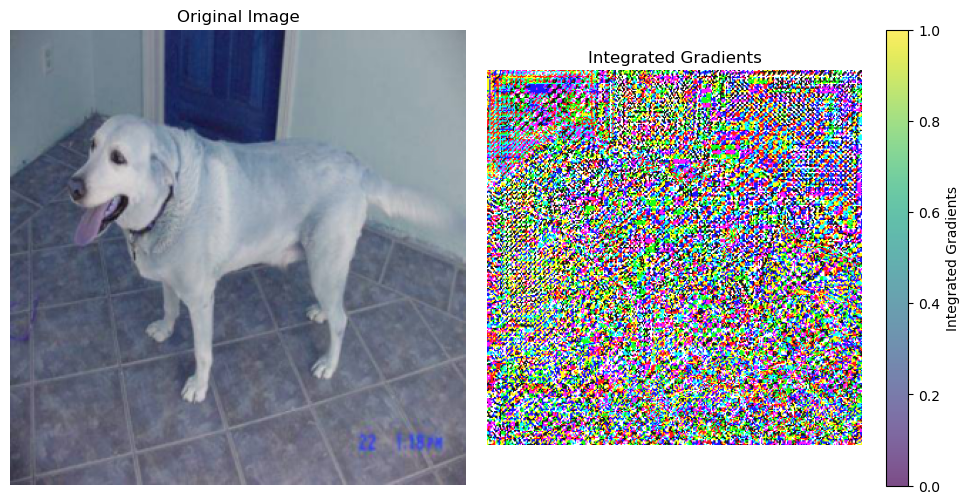

In [9]:
# ANALYZE GRADIENTS

rand_img_path = f'{Config.PATH_DATA}test1/{".".join(random.choice(test_image_paths).split("."))}'
img = plt.imread(rand_img_path)
img = cv2.resize(img, Config.IMAGE_SIZE_TEST, interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(rand_img_path)

img_original = img.copy()

img = val_transforms(image=img)["image"]
img = img.unsqueeze(0)

input_name = ort_session.get_inputs()[0].name
input_data = img.numpy()

pred = ort_session.run(None, {input_name: input_data})[0]
sigmoid_output = torch.sigmoid(torch.from_numpy(pred)).item()

print(sigmoid_output)

ig = IntegratedGradients(best_model)

attributions, delta = ig.attribute(img, target=0, return_convergence_delta=True)

attributions = attributions.squeeze().cpu().detach().numpy()
attributions = np.transpose(attributions, (1, 2, 0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_original)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(attributions, cmap="viridis", alpha=0.7)
ax2.set_title("Integrated Gradients")
ax2.axis("off")

plt.colorbar(
    ax2.imshow(attributions, cmap="viridis", alpha=0.7), ax=ax2, label="Integrated Gradients"
)

plt.tight_layout()
plt.show()